# ensemble-boxes

複数のモデルの出力をwbfでアンサンブル

In [1]:
!pip install -q imagesize

In [2]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
sys.path.append('../input/tensorflow-great-barrier-reef')
import torch
from PIL import Image
import ast
import imagesize

In [3]:
ROOT_DIR  = '/workspace/cots/data/'
CKPT_PATH1 = '/workspace/cots/yolov5/runs/train/exp2/weights/best.pt'
CKPT_PATH2 = '/workspace/cots/yolov5/runs/train/exp4/weights/best.pt'
IMG_SIZE  = 1280
CONF      = 0.15
IOU       = 0.50
AUGMENT   = False

# ヘルパー関数

In [4]:
def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [5]:
def get_path(row):
    row['image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row


def load_model(ckpt_path, conf=0.25, iou=0.50, device=0):
    model = torch.hub.load('/workspace/cots/yolov5',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True,
                           device=device)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model


def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot


def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

# 推論

データ読み込み

In [6]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df = df.apply(get_path, axis=1)
df['annotations'] = df['annotations'].apply(lambda x: ast.literal_eval(x))
display(df.head(2))

# num_bbox作成
df['num_bbox'] = df['annotations'].apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts()/len(df)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

df = df.apply(get_imgsize,axis=1)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                         image_path  
0  /workspace/cots/data//train_images/video_0/0.jpg  
1  /workspace/cots/data//train_images/video_0/1.jpg

No BBox: 79.07% | With BBox: 20.93%


モデル読み込み

In [7]:
model1 = load_model(CKPT_PATH1, conf=CONF, iou=IOU, device=3)

YOLOv5 🚀 v6.0-128-g581dc30 torch 1.8.1 CUDA:3 (Tesla V100-PCIE-32GB, 32510MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [8]:
model2 = load_model(CKPT_PATH2, conf=CONF, iou=IOU, device=3)

YOLOv5 🚀 v6.0-128-g581dc30 torch 1.8.1 CUDA:3 (Tesla V100-PCIE-32GB, 32510MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients
Adding AutoShape... 


# ensemble

In [9]:
!pip install ensemble-boxes

     |████████████████████████████████| 3.3 MB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 26.3 MB 74.4 MB/s eta 0:00:01


In [39]:
from ensemble_boxes import *

In [87]:
def predict_wbf_format(model, img, size=1280, augment=False):
    """
    wbfに必要なobject毎の
    * bbox(0 ~ 1に正規化)
    * confidence score
    * label (今回はオニヒトデだけなのであまり関係ないが、wbfに必要)
    """
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    # normalizing
    preds[['xmin', 'xmax']] = preds[['xmin', 'xmax']] / width
    preds[['ymin', 'ymax']] = preds[['ymin', 'ymax']] / height
    
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    
    if len(bboxes):
        confs   = preds.confidence.values
        labels = preds['class'].values
        return bboxes, confs, labels
    else:
        return [], [], []

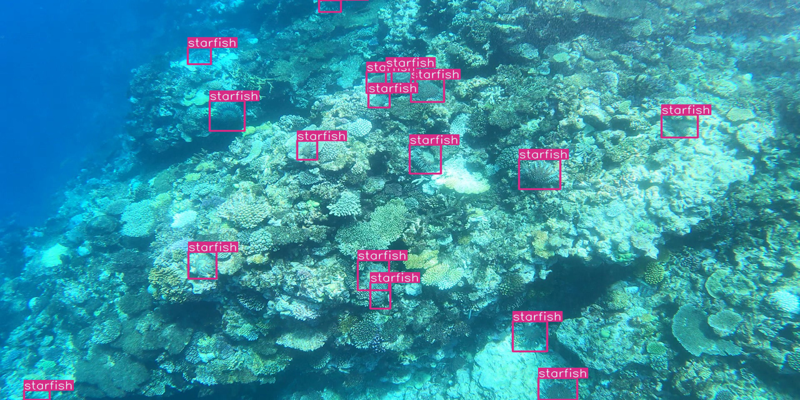

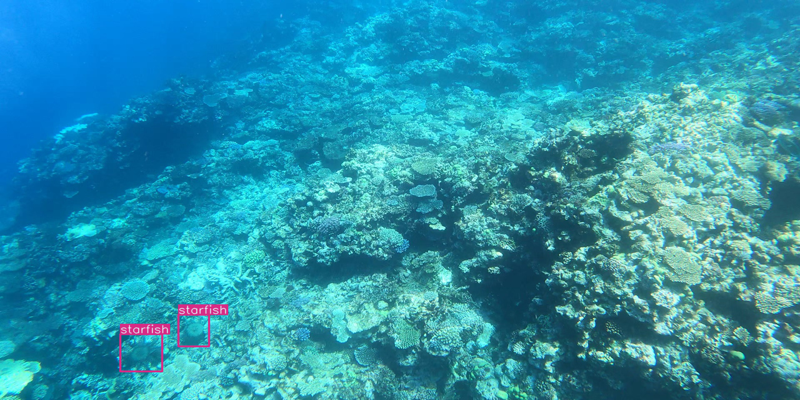

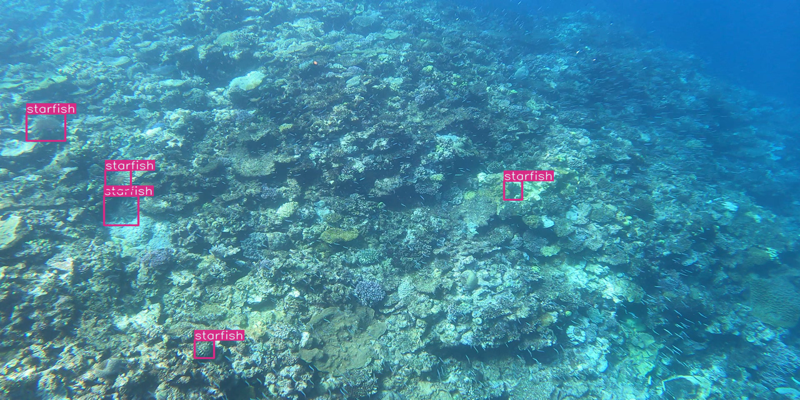

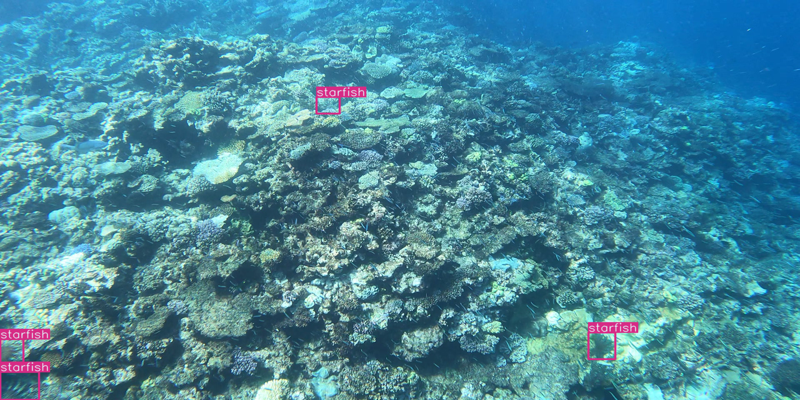

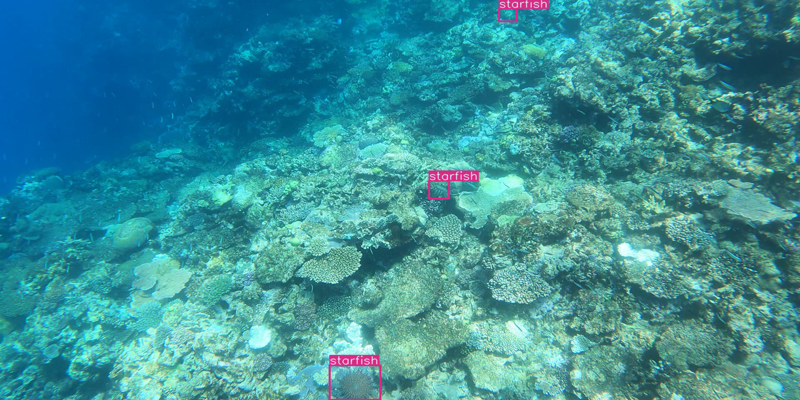

In [92]:
image_paths = df[df.num_bbox>1].sample(100).image_path.tolist()
for idx, path in enumerate(image_paths):
    img = cv2.imread(path)[...,::-1]
    height, width = img.shape[:2]
    bboxes1, confis1, labels1 = predict_wbf_format(model1, img, size=IMG_SIZE, augment=AUGMENT)
    bboxes2, confis2, labels2 = predict_wbf_format(model2, img, size=IMG_SIZE, augment=AUGMENT)

    boxes_list = list([bboxes1.tolist(), bboxes2.tolist()])
    confis_list = list([confis1.tolist(), confis2.tolist()])
    labels_list = list([labels1.tolist(), labels2.tolist()])
    weights = [2, 1]

    boxes, confis, labels = weighted_boxes_fusion(boxes_list, confis_list, labels_list, weights=weights, iou_thr=0.5, skip_box_thr=0.0001)
    # x1, y1, x2, y2
    boxes = boxes * (width, height, width, height)
    bboxes = voc2coco(boxes,height,width).astype(int)    
    display(show_img(img, bboxes, bbox_format='coco'))
    if idx>3:
        break